# Catalyst Cooperative Jupyter Notebook Template
This notebook lays out a standard format and some best practices for creating interactive / exploratory notebooks which can be relatively easily shared between different PUDL users, and turned into reusable Python modules for integration into our underlying Python packages.

## Begin with a narrative outline
Each notebook should start with a brief explanation (in Markdown) explaining the purpose of the analysis, and outlining the different stages / steps which are taken to accomplish the analysis.
As the analysis develops, you can add new sections or details to this section.

## Notebooks should be runnable
Insofar as it's possible, another PUDL user who has cloned the repository that the notebook is part of should be able to update their `pudl-dev` conda environment, open the notebook, and run all cells successfully.
If there are required data or other prerequisites that the notebook cannot manage on its own -- like a file that needs to be downloaded by hand and placed in a particular location -- those steps should be laid out clearly at the beginning of the notebook.

## Avoid Troublesome Elements

### Don't hardcode passwords or access tokens
Most of our work is done in public Github repositories.
No authentication information should ever appear in a notebook.
These values can be stored in environment variables on your local computer.

### Do not hardocde values, especially late in the notebook
If the analysis depends on particular choices of input values, those should be called out explicitly at the beginning of the notebook.
(NB: We should explore ways to parameterize notebooks, [papermill](https://papermill.readthedocs.io/en/latest/) is one tool that does this).

### Don't hardcode absolute file paths
If anyone is going to be able to use the notebook, the files it uses will need to be stored somewhere that makes sense on both your and other computers.
We assume that anyone using this template has the PUDL package installed, and has a local PUDL data management environment set up.
  * Input data that needs to be stored on disk and accessed via a shared location should be saved under `<PUDL_IN>/data/local/<data_source>/`.
  * Intermediate saved data products (e.g. a pickled result of a computationally intensive process) and results should be saved to a location relative to the notebook, and within the directory hierarchy of the repository that the notebook is part of.
  
### Don't require avoidable long-running computations
Consider persisting to disk the results of computations that take more than a few minutes, if the outputs are small enough to be checked into the repository and shared with other users.
Only require the expensive computation to be run if this pre-computed output is not available.

### Don't litter
Don't leave lots of additional code laying around, even commented out, "just in case" you want to look at it again later.
Notebooks need to be relatively linear in the end, even though the thought processes and exploratory analyses that generate them may not be.
Once you have a working analysis, either prune those branches, or encapsulate them as options within functions.

### Don't load unneccesary libraries
Only import libraries which are required by the notebook, to avoid unnecessary dependencies.
If your analysis requires a new library that isn't yet part of the shared `pudl-dev` environment, add it to the `devtools/environment.yml` file so that others will get it when they update their environment.

## Related Resources:
Lots of these guidelines are taken directly from Emily Riederer's post: [RMarkdown Driven Development](https://emilyriederer.netlify.app/post/rmarkdown-driven-development/).
For more in depth explanation of the motivations behind this layout, do go check it out!

# Import Libraries
* Because it's very likely that you will be editing the PUDL Python packages or your own local module under development while working in the notebook, use the %autoreload magic with autoreload level 2 to ensure that any changes you've made in those files are always reflected in the code that's running in the notebook.
* Put all import statements at the top of the notebook, so everyone can see what its dependencies are up front, and so that if an import is going to fail, it fails early, before the rest of the notebook is run.
* Try to avoid importing individual functions and classes from deep within packages, as it may not be clear to other users where those elements came from, later in the notebook, and also to minimize the chance of namespace collisions.

In [1]:
%load_ext autoreload
%autoreload 2

In [217]:
# Standard libraries
import logging
import os
import pathlib
import sys

# 3rd party libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa

# Local libraries
import pudl

# Configure Display Parameters

In [218]:
sns.set()
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Use Python Logging facilities
* Using a logger from the beginning will make the transition into the PUDL package easier.
* Creating a logging handler here will also allow you to see the logging output coming from PUDL and other underlying packages.

In [219]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

# Define Functions
In many cases, the eventual product of a notebook analysis is going to be the creation of new, reusable functions that are integrated into the underlying PUDL code. You should begin the process of accumulating and organizing those functions as soon as you notice repeated patterns in your code.
* Functions should be used to encapsulate any potentially reusable code.
* Functions should be defined immediately after the imports, to avoid accidental dependence on zombie variables that are defined further down in the code
* While they may evolve over time, having brief docstrings explaining what they do will help others understand them.
* If there's a particular type of plot or visualization that is made repeatedly in the notebook, it's good to parameterize and functionalize it here too, so that as you refine the presentation of the data and results, those improvements can be made in a single place, and shown uniformly throughout the notebook.
* As these functions mature and become more general purpose tools, you will probably want to start migrating them into their own local module, under a `src` directory in the same directory as the notebook. You will want to import this module 

## Dummy EIA 861 ETL

In [220]:
def test_etl_eia(eia_inputs, pudl_settings):
    """
    This is a dummy function that runs the first part of the EIA ETL
    process -- everything up until the entity harvesting begins. For
    use in this notebook only.

    """
    eia860_tables = eia_inputs["eia860_tables"]
    eia860_years = eia_inputs["eia860_years"]
    eia861_tables = eia_inputs["eia861_tables"]
    eia861_years = eia_inputs["eia861_years"]
    eia923_tables = eia_inputs["eia923_tables"]
    eia923_years = eia_inputs["eia923_years"]

    # generate CSVs for the static EIA tables, return the list of tables
    #static_tables = _load_static_tables_eia(datapkg_dir)

    # Extract EIA forms 923, 860
    eia860_raw_dfs = pudl.extract.eia860.Extractor().extract(eia860_years, testing=True)
    eia861_raw_dfs = pudl.extract.eia861.Extractor().extract(eia861_years, testing=True)
    eia923_raw_dfs = pudl.extract.eia923.Extractor().extract(eia923_years, testing=True)

    # Transform EIA forms 860, 861, 923
    eia860_transformed_dfs = pudl.transform.eia860.transform(eia860_raw_dfs, eia860_tables=eia860_tables)
    eia861_transformed_dfs = pudl.transform.eia861.transform(eia861_raw_dfs, eia861_tables=eia861_tables)
    eia923_transformed_dfs = pudl.transform.eia923.transform(eia923_raw_dfs, eia923_tables=eia923_tables)

    # create an eia transformed dfs dictionary
    eia_transformed_dfs = eia860_transformed_dfs.copy()
    eia_transformed_dfs.update(eia861_transformed_dfs.copy())
    eia_transformed_dfs.update(eia923_transformed_dfs.copy())

    # convert types..
    eia_transformed_dfs = pudl.helpers.convert_dfs_dict_dtypes(eia_transformed_dfs, 'eia')

    return eia860_raw_dfs, eia861_raw_dfs, eia923_raw_dfs, eia_transformed_dfs

# Define Notebook Parameters
If there are overarching parameters which determine the nature of the analysis -- which US states to look at, which utilities are of interest, a particular start and end date -- state those clearly at the beginning of the analysis, so that they can be referred to by the rest of the notebook and easily changed if need be.
* If the analysis depends on local (non-PUDL managed) datasets, define the paths to those data here.
* If there are external URLs or other resource locations that will be accessed, define those here as well.
* This is also where you should create your `pudl_settings` dictionary and connections to your local PUDL databases

In [221]:
EIA861_YEARS = list(range(2001, 2019))
pudl_settings = pudl.workspace.setup.get_defaults()
display(pudl_settings)

ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
display(ferc1_engine)

pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
display(pudl_engine)

# Is there other external data you need to pull in?
# If so, put it in a (relatively) standard place on the filesystem.
my_new_data_url = "https://mynewdata.website.gov/path/to/new/data.csv"
my_new_datadir = pathlib.Path(pudl_settings["data_dir"]) / "local/new_data_source"

# Store API keys and other secrets in environment variables
# and read them in here, if needed:
# API_KEY_EIA = os.environ["API_KEY_EIA "]
# API_KEY_FRED = os.environ["API_KEY_FRED "]

{'pudl_in': '/Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR',
 'data_dir': '/Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/data',
 'settings_dir': '/Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/settings',
 'pudl_out': '/Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR',
 'sqlite_dir': '/Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/sqlite',
 'parquet_dir': '/Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/parquet',
 'datapkg_dir': '/Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/datapkg',
 'notebook_dir': '/Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/notebook',
 'ferc1_db': 'sqlite:////Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/sqlite/pudl.sqlite'}

Engine(sqlite:////Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/sqlite/ferc1.sqlite)

Engine(sqlite:////Users/aesharpe/Desktop/Work/Catalyst_Coop/PUDL_DIR/sqlite/pudl.sqlite)

# Load Data
* Given the above parameters and functions, it should now be possible to load the required data into local variables for further wrangling, analysis, and visualization.
* If the data is not yet present on the machine of the person running the notebook, this step should also acquire the data from its original source, and place it in the appropriate location under `<PUDL_IN>/data/local/`.
* If there are steps which have to be done manually here, put them first so that they fail first if the user hasn't read the instructions, and they can fix the situation before a bunch of other work gets done. Try to minimize the amount of work in the filesystem that has to be done manually though.
* If this process takes a little while, don't be shy about producing `logging` output.
* Using the `%%time` cell magic can also help users understand which pieces of work / data acquisition are hard:

## EIA 861 (2010-2018)
* Not yet fully integrated into PUDL
* Post-transform harvesting process isn't compatible w/ EIA 861 structure
* Only getting the `sales_eia861`, `balancing_authority_eia861`, and `service_territory_eia861` tables

### Already Transformed EIA 861 DataFrames

In [222]:
%%time
eia_inputs = {
    "eia860_years": [],
    "eia860_tables": pudl.constants.pudl_tables["eia860"],
    "eia861_years": EIA861_YEARS,
    "eia861_tables": pudl.constants.pudl_tables["eia861"],
    "eia923_years": [],
    "eia923_tables": pudl.constants.pudl_tables["eia923"],
}
eia860_raw_dfs, eia861_raw_dfs, eia923_raw_dfs, eia_transformed_dfs = test_etl_eia(eia_inputs=eia_inputs, pudl_settings=pudl_settings)

No years given. Not extracting eia860 spreadsheet data.
No page for eia861 advanced_metering_infrastructure_eia861 2001
No page for eia861 advanced_metering_infrastructure_eia861 2002
No page for eia861 advanced_metering_infrastructure_eia861 2003
No page for eia861 advanced_metering_infrastructure_eia861 2004
No page for eia861 advanced_metering_infrastructure_eia861 2005
No page for eia861 advanced_metering_infrastructure_eia861 2006
Loading dataframe for eia861 advanced_metering_infrastructure_eia861 2007
Loading dataframe for eia861 advanced_metering_infrastructure_eia861 2008
Loading dataframe for eia861 advanced_metering_infrastructure_eia861 2009
Loading dataframe for eia861 advanced_metering_infrastructure_eia861 2010
Loading dataframe for eia861 advanced_metering_infrastructure_eia861 2011
Loading dataframe for eia861 advanced_metering_infrastructure_eia861 2012
Loading dataframe for eia861 advanced_metering_infrastructure_eia861 2013
Loading dataframe for eia861 advanced_mete

# Sanity Check Data
If there's any validation that can be done on the data which you've loaded to flag if/when it is inappropriate for the analysis that follows, do it here. If you find the data is unusable, use `assert` statements or `raise` Exceptions to stop the notebook from proceeding, and indicate what the problem is.

In [223]:
list(eia861_raw_dfs.keys())

['advanced_metering_infrastructure_eia861',
 'balancing_authority_eia861',
 'demand_response_eia861',
 'demand_side_management_eia861',
 'distributed_generation_eia861',
 'distribution_systems_eia861',
 'dynamic_pricing_eia861',
 'frame_eia861',
 'green_pricing_eia861',
 'mergers_eia861',
 'net_metering_eia861',
 'non_net_metering_eia861',
 'operational_data_eia861',
 'reliability_eia861',
 'sales_eia861',
 'service_territory_eia861',
 'short_form_eia861',
 'utility_data_eia861']

In [224]:
list(eia_transformed_dfs.keys())

['service_territory_eia861',
 'balancing_authority_eia861',
 'sales_eia861',
 'demand_response_eia861',
 'distribution_systems_eia861']

In [229]:
eia_transformed_dfs['demand_response_eia861']

,utility_id_eia,state,balancing_authority_code_eia,utility_name_eia,water_heater,customer_class,actual_peak_demand_savings_mw,customer_incentives_cost,customers,energy_savings_mwh,other_costs,potential_peak_demand_savings_mw,report_date
0,84,VA,UNK,A & N Electric Coop,<NA>,commercial,0.0,NaN,0,0.0,NaN,0.0,2013-01-01
1,84,VA,UNK,A & N Electric Coop,<NA>,industrial,0.0,NaN,0,0.0,NaN,0.0,2013-01-01
2,84,VA,UNK,A & N Electric Coop,<NA>,residential,1.4,21000.0,2200,100.0,NaN,1.4,2013-01-01
4,84,VA,UNK,A & N Electric Coop,<NA>,transportation,NaN,NaN,<NA>,NaN,NaN,NaN,2013-01-01
5,97,IL,UNK,Adams Electric Coop,91,commercial,NaN,NaN,60,NaN,NaN,4.0,2013-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13299,60482,OK,SWPP,CKenergy Electric Cooperative,<NA>,transportation,0.0,NaN,0,NaN,0.0,0.0,2018-01-01
13300,60631,MI,MISO,Upper Michigan Energy Resources Corp.,<NA>,commercial,NaN,NaN,1,NaN,NaN,0.0,2018-01-01
13301,60631,MI,MISO,Upper Michigan Energy Resources Corp.,<NA>,industrial,NaN,NaN,6,NaN,NaN,19.9,2018-01-01
13302,60631,MI,MISO,Upper Michigan Energy Resources Corp.,<NA>,residential,NaN,NaN,74,NaN,NaN,0.1,2018-01-01


# Preliminary Data Wrangling
Once all of the data is loaded and looks like it's in good shape, do any initial wrangling that's specific to this particular analysis. This should mostly make use of the higher level functions which were defined above. If this step takes a while, don't be shy about producing `logging` outputs.

In [198]:
eia_transformed_dfs['distribution_systems_eia861']

,circuits_with_voltage_optimization,distribution_circuits,state,utility_id_eia,utility_name_eia,report_date
0,8,8,MS,55,City of Aberdeen - (MS),2016-01-01
1,0,15,LA,59,City of Abbeville - (LA),2016-01-01
2,0,1,MD,84,A & N Electric Coop,2016-01-01
3,0,43,VA,84,A & N Electric Coop,2016-01-01
4,47,47,IL,97,Adams Electric Coop,2016-01-01
...,...,...,...,...,...,...
5886,0,4,CA,60502,Port of Stockton - (CA),2018-01-01
5887,0,64,MI,60631,Upper Michigan Energy Resources Corp.,2018-01-01
5888,<NA>,20,CA,60715,Port of Oakland,2018-01-01
5889,0,81,KS,60839,Southern Pioneer Electric Company,2018-01-01


#### DSM Stuff

In [42]:
dsm = eia861_raw_dfs['demand_side_management_eia861'].copy()
dsm.columns.tolist()

['AK',
 'ECAR',
 'ERCOT',
 'FRCC',
 'HI',
 'MAAC',
 'MAIN',
 'MAPP',
 'NPCC',
 'PR',
 'SERC',
 'SPP',
 'WSCC',
 'annual_energy_efficiency_cost',
 'annual_incentive_payment_energy_efficiency',
 'annual_incentive_payment_load_management',
 'annual_indirect_utility_cost',
 'annual_load_management_cost',
 'annual_total_utility_cost',
 'ba_code',
 'commercial_annual_energy_efficiency_actual_peak_reduction',
 'commercial_annual_energy_efficiency_cost',
 'commercial_annual_energy_efficiency_energy_effects ',
 'commercial_annual_load_management_actual_peak_reduction',
 'commercial_annual_load_management_cost ',
 'commercial_annual_load_management_energy_effects ',
 'commercial_annual_load_management_potential_peak_reduction',
 'commercial_customer_incentives_incremental_cost',
 'commercial_customer_incentives_incremental_life_cycle_cost',
 'commercial_customer_other_costs_incremental_life_cycle_cost',
 'commercial_energy_efficiency_annual_incentive_payment',
 'commercial_incremental_energy_eff

In [50]:
idx_cols = ['utility_id_eia', 'state', 'ba_code', 'report_year']

dsm_test = dsm[['utility_id_eia', 'state', 'ba_code', 'report_year', 
                'residential_annual_load_management_energy_effects ', 
                'commercial_annual_load_management_energy_effects ', 
                'industrial_annual_load_management_energy_effects ',
                'transportation_annual_load_management_energy_effects ',
                'total_annual_load_management_energy_effects ',
]]

dr_test = raw_dr_eia861[['utility_id_eia', 'state', 'balancing_authority_code_eia', 'report_year',
                         'residential_energy_savings_mwh',
                         'commercial_energy_savings_mwh',
                         'industrial_energy_savings_mwh',
                         'transportation_energy_savings_mwh',
                         'total_energy_savings_mwh'
]].rename(columns={'balancing_authority_code_eia': 'ba_code'})

In [84]:
merge = pd.merge(dsm_test, dr_test, on=idx_cols, how='outer')
merge = pudl.helpers.oob_to_nan(merge, 
                       ['residential_annual_load_management_energy_effects ', 
                        'commercial_annual_load_management_energy_effects ', 
                        'industrial_annual_load_management_energy_effects ',
                        'transportation_annual_load_management_energy_effects ',
                        'residential_energy_savings_mwh',
                        'commercial_energy_savings_mwh',
                        'industrial_energy_savings_mwh',
                        'transportation_energy_savings_mwh',
                        'total_energy_savings_mwh',
                        'total_annual_load_management_energy_effects '])

In [71]:
dr_col = 'residential_energy_savings_mwh'
dsm_col = 'residential_annual_load_management_energy_effects '

In [85]:
merge = merge.loc[merge['report_year'].isin(range(2012,2014))]
merge = merge.loc[merge[dr_col].notna()]
#merge = merge.loc[merge[dsm_col].notna()]
merge

,utility_id_eia,state,ba_code,report_year,residential_annual_load_management_energy_effects,commercial_annual_load_management_energy_effects,industrial_annual_load_management_energy_effects,transportation_annual_load_management_energy_effects,total_annual_load_management_energy_effects,residential_energy_savings_mwh,commercial_energy_savings_mwh,industrial_energy_savings_mwh,transportation_energy_savings_mwh,total_energy_savings_mwh
15612,84.0,VA,NaN,2013,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,NaN,100.0
15614,108.0,WI,NaN,2013,NaN,NaN,NaN,NaN,NaN,1444.0,NaN,6303.0,NaN,7747.0
15615,189.0,AL,NaN,2013,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
15616,195.0,AL,NaN,2013,NaN,NaN,NaN,NaN,NaN,323.0,2331.0,2230.0,NaN,4884.0
15619,309.0,IA,NaN,2013,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16005,20885.0,FL,NaN,2013,NaN,NaN,NaN,NaN,NaN,1004.0,528.0,NaN,NaN,1532.0
16014,24949.0,ND,NaN,2013,NaN,NaN,NaN,NaN,NaN,11810.0,4535.0,2035.0,NaN,18380.0
16024,40228.0,VA,NaN,2013,NaN,NaN,NaN,NaN,NaN,11.0,24.0,4.0,0.0,39.0
16025,44372.0,TX,NaN,2013,NaN,NaN,NaN,NaN,NaN,0.0,226.0,0.0,0.0,226.0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


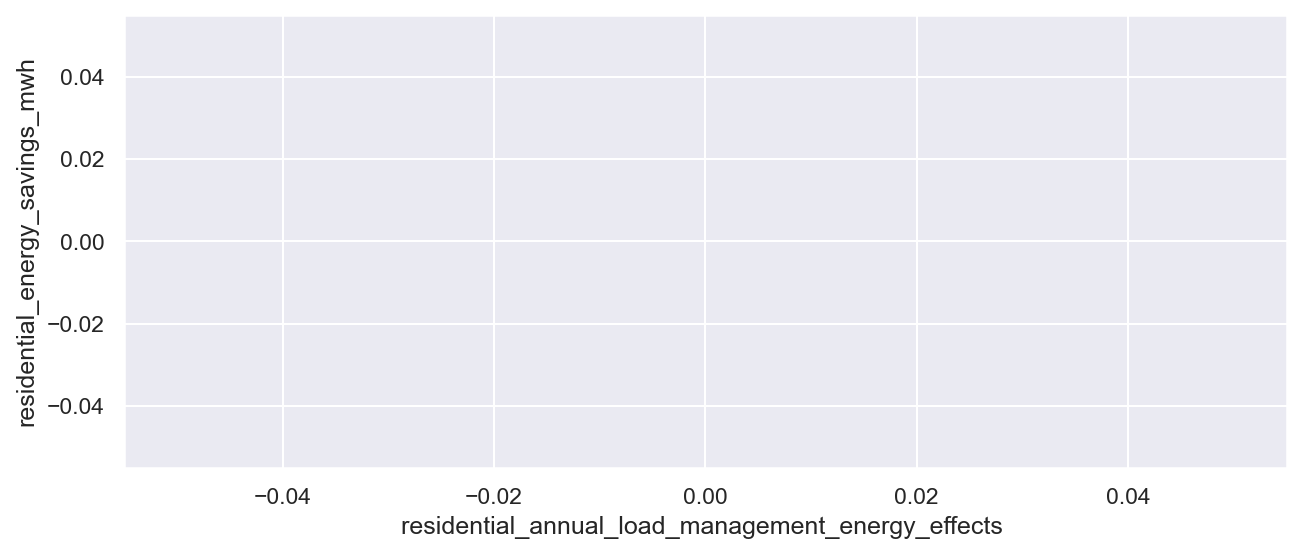

In [73]:
test.plot.scatter('residential_annual_load_management_energy_effects ', 'residential_energy_savings_mwh')

In [37]:
raw_dr_eia861.columns.tolist()

['balancing_authority_code_eia',
 'commercial_actual_peak_demand_savings_mw',
 'commercial_customer_incentives_cost',
 'commercial_customers',
 'commercial_energy_savings_mwh',
 'commercial_other_costs',
 'commercial_potential_peak_demand_savings_mw',
 'industrial_actual_peak_demand_savings_mw',
 'industrial_customer_incentives_cost',
 'industrial_customers',
 'industrial_energy_savings_mwh',
 'industrial_other_costs',
 'industrial_potential_peak_demand_savings_mw',
 'report_year',
 'residential_actual_peak_demand_savings_mw',
 'residential_customer_incentives_cost',
 'residential_customers',
 'residential_energy_savings_mwh',
 'residential_other_costs',
 'residential_potential_peak_demand_savings_mw',
 'state',
 'total_actual_peak_demand_savings_mw',
 'total_customer_incentives_cost',
 'total_customers',
 'total_energy_savings_mwh',
 'total_other_costs',
 'total_potential_peak_demand_savings_mw',
 'transportation_actual_peak_demand_savings_mw',
 'transportation_customer_incentives_cos

## Demand Response

In [34]:
raw_dr_eia861 = eia861_raw_dfs["demand_response_eia861"].copy()
tfr_dr_eia861 = eia_transformed_dfs["demand_response_eia861"].copy()

In [11]:
raw_dr_eia861.sample(10)

,balancing_authority_code_eia,commercial_actual_peak_demand_savings_mw,commercial_customer_incentives_cost,commercial_customers,commercial_energy_savings_mwh,commercial_other_costs,commercial_potential_peak_demand_savings_mw,industrial_actual_peak_demand_savings_mw,industrial_customer_incentives_cost,industrial_customers,industrial_energy_savings_mwh,industrial_other_costs,industrial_potential_peak_demand_savings_mw,report_year,residential_actual_peak_demand_savings_mw,residential_customer_incentives_cost,residential_customers,residential_energy_savings_mwh,residential_other_costs,residential_potential_peak_demand_savings_mw,state,total_actual_peak_demand_savings_mw,total_customer_incentives_cost,total_customers,total_energy_savings_mwh,total_other_costs,total_potential_peak_demand_savings_mw,transportation_actual_peak_demand_savings_mw,transportation_customer_incentives_cost,transportation_customers,transportation_energy_savings_mwh,transportation_other_costs,transportation_potential_peak_demand_savings_mw,utility_id_eia,utility_name_eia,water_heater
1025,NaN,0.5,1,6,,,0.5,,,,,,,2015,6.7,8,495,,,6.7,MA,7.2,9,501,,,7.2,,,,,,,4147,Town of Concord - (MA),12
944,NaN,.,.,.,.,.,.,.,.,.,.,.,.,2014,2,118,74,8,107,2.5,IN,2,118,74,8,107,2.5,.,.,.,.,.,.,40211,"Wabash Valley Power Assn, Inc",0
2429,WAUW,.,.,.,.,.,.,.,.,.,.,.,.,2018,0.2,0,33,96,0,0.2,MT,0.2,0,33,96,0,0.2,.,.,.,.,.,.,12463,"Mid-Yellowstone Elec Coop, Inc",.
153,NaN,39,.,5067,636,.,70,.,.,.,.,.,.,2013,24,.,28862,398,.,31,FL,63,.,33929,1034,.,101,.,.,.,.,.,.,9616,Beaches Energy Services,.
591,NaN,9,0,101,0,4,9.9,0,0,0,0,0,0,2014,1.8,1019,4972,0,192,2,WI,10.8,1019,5073,0,196,11.9,0,0,0,0,0,0,8574,"Jackson Electric Coop, Inc - (WI)",.
2251,MISO,0.4,.,35,.,.,0.4,.,.,.,.,.,.,2018,2.6,1,968,.,9,3.4,MN,3,1,1003,.,9,3.8,.,.,.,.,.,.,1573,City of Benson - (MN),.
2209,MISO,.,.,.,.,.,.,.,.,.,.,.,.,2017,11.9,716,2227,799,30,44,MN,11.9,716,2227,799,30,44,.,.,.,.,.,.,26934,"Red Lake Electric Coop, Inc",.
1192,NaN,,19,480,,6,,,,,,,,2015,17,1012,22842,,333,17,IN,17,1031,23322,,339,17,,,,,,,13756,Northern Indiana Pub Serv Co,
2076,PJM,.,.,.,.,.,.,.,.,.,.,.,.,2017,20.8,888,25386,2500,847,20.8,DC,20.8,888,25386,2500,847,20.8,.,.,.,.,.,.,15270,Potomac Electric Power Co,.
812,NaN,.,.,.,.,.,.,.,.,.,.,.,.,2014,.,23,1900,.,19,1.9,MN,.,23,1900,.,19,1.9,.,.,.,.,.,.,16971,Shakopee Public Utilities Comm,.


In [12]:
tfr_dr_eia861.sample(10)

,utility_id_eia,state,balancing_authority_code_eia,utility_name_eia,water_heater,customer_class,actual_peak_demand_savings_mw,customer_incentives_cost,customers,energy_savings_mwh,other_costs,potential_peak_demand_savings_mw,report_date
3937,15746,OK,UNK,Red River Valley Rrl Elec Assn,<NA>,residential,NaN,NaN,<NA>,NaN,NaN,NaN,2014-01-01
11125,40212,GA,SOCO,Colquitt Electric Membership Corp,<NA>,commercial,1.0,NaN,8,16.0,5000.0,1.0,2017-01-01
4926,1573,MN,UNK,City of Benson - (MN),<NA>,industrial,0.0,NaN,0,NaN,NaN,0.0,2015-01-01
10285,14063,OK,SWPP,Oklahoma Gas & Electric Co,<NA>,commercial,18.2,4430000.0,10311,12947.0,247000.0,123.0,2017-01-01
9230,2643,NE,SWPP,Butler Public Power District - (NE),<NA>,commercial,NaN,NaN,<NA>,NaN,NaN,NaN,2017-01-01
2010,24949,ND,UNK,Cass County Elec Coop Inc,24,commercial,29.4,6955000.0,400,4535.0,21000.0,108.9,2013-01-01
5291,5632,WI,UNK,Eau Claire Electric Coop,44,industrial,0.0,0.0,0,0.0,0.0,0.0,2015-01-01
11467,3989,CO,WACM,City of Colorado Springs - (CO),<NA>,residential,1.0,0.0,1719,0.0,177000.0,1.9,2018-01-01
9669,7140,GA,SOCO,Georgia Power Co,<NA>,transportation,NaN,NaN,<NA>,NaN,NaN,NaN,2017-01-01
3527,13481,WI,UNK,City of New Richmond,0,residential,NaN,NaN,<NA>,NaN,NaN,NaN,2014-01-01


In [13]:
tfr_dr_eia861.duplicated(subset=["report_date", "utility_id_eia", "state", "balancing_authority_code_eia", "customer_class"], keep=False).value_counts()

False    10580
dtype: int64

In [14]:
tfr_dr_eia861.customer_class.unique()

[commercial, industrial, residential, transportation]
Categories (4, object): [commercial, industrial, residential, transportation]

# Data Analysis and Visualization
* Now that you've got the required data in a usable form, you can tell the story of your analysis through a mix of visualizations, and further data wrangling steps.
* This narrative should be readable, with figures that have titles, legends, and labeled axes as appropriate so others can understand what you're showing them.
* The code should be concise and make use of the parameters and functions which you've defined above when possible. Functions should contain comprehensible chunks of work that make sense as one step in the story of the analysis.